## Introduction

The Steam reviews dataset from Kaggle consists of the game, its review, and review_score. Users can submit their review as either 1 for Recommend, or -1 for not Recommend. I will use RNN with LSTM to predict if the given review text will classify into either Recommend or Not Recommend.

Dataset: https://www.kaggle.com/datasets/andrewmvd/steam-reviews/code

In [ ]:
# Randomly select 5% of the dataset records.

In [1]:
import pandas as pd
import numpy as np

# Assuming the CSV file is in the same directory
file_path = "dataset.csv"

# Read the CSV file
df = pd.read_csv(file_path)

# Specify the fraction of rows you want to keep (e.g., 0.05 for keeping 5%)
fraction_to_keep = 0.05

# Generate a boolean mask of rows to keep randomly
mask = np.random.rand(len(df)) < fraction_to_keep

# Keep only the rows that satisfy the mask
df_filtered = df[mask]

# Now, 'df_filtered' contains the DataFrame with a random subset of rows
# You can save this DataFrame to a new CSV file, 
# and work with the new file
df_filtered.to_csv("filtered_dataset.csv", index=False)

In [2]:
### Load the new dataset:

file_path = "filtered_dataset.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Now, 'df' contains your data, and you can perform various operations on it
# For example, you can display the first few rows of the DataFrame
print(df.head())

   app_id        app_name                                        review_text  \
0      10  Counter-Strike          Still better than Call of Duty: Ghosts...   
1      10  Counter-Strike   After 14 years of existence, this legendary g...   
2      10  Counter-Strike    Pros  - No crates which you can waste your m...   
3      10  Counter-Strike  Compared to CS:GO, this is pure gold. Joined a...   
4      10  Counter-Strike  First starting off as a cute, little mod based...   

   review_score  review_votes  
0             1             1  
1             1             0  
2             1             1  
3             1             1  
4             1             1  


In [3]:
df.shape

(320772, 5)

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import re
import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from nltk.corpus import stopwords
from string import punctuation
# pd.set_option('display.max_colwidth', None)

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        320772 non-null  int64 
 1   app_name      311746 non-null  object
 2   review_text   320415 non-null  object
 3   review_score  320772 non-null  int64 
 4   review_votes  320772 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ MB


In [11]:
#sample 10 random rows to see what other games are there
#https://datatofish.com/random-rows-pandas-dataframe/
df.sample(n=10)

,app_id,app_name,review_text,review_score,review_votes
312760,7520,Two Worlds II,The good - graphics - the magic system The ba...,-1,0
239787,367500,Dragon's Dogma: Dark Arisen,Only need 30 min to make sure it was ported co...,1,0
82713,225600,Blade Symphony,The community is mean. They make fun of me :(,1,0
271594,422970,Devil Daggers,It's a shame when developers don't trust their...,-1,1
27287,203160,Tomb Raider,The Tomb Raider reboot is an amazing represent...,1,0
190088,301520,Robocraft,Early Access Review,1,0
42010,21090,F.E.A.R.,"Awesome game, not the scariest but sometimes m...",1,0
166549,273350,Evolve Stage 2,the game is loads of fun and i am constantly t...,1,0
97318,233450,Prison Architect,gr8 story tbh,1,0
276478,433850,Z1 Battle Royale,Early Access Review,1,0


In [12]:
#Retrieve row based on specific value in column
#https://www.statology.org/pandas-select-rows-based-on-column-values/
game = "Undertale"
df.loc[df['app_name'] == game]

,app_id,app_name,review_text,review_score,review_votes
255295,391540,Undertale,This game is a dating sim This game is a horro...,1,0
255296,391540,Undertale,You should totally play this if you enjoy; -Ea...,1,1
255297,391540,Undertale,"If you like spaghetti and crying alot, BUY THI...",1,0
255298,391540,Undertale,Pros: - Amazing music. - Amazing characters....,1,1
255299,391540,Undertale,"All right, this game is epic. There is just fe...",1,1
...,...,...,...,...,...
257787,391540,Undertale,the feels with this are out of this world.if y...,1,0
257788,391540,Undertale,One of the best experience in a video game tha...,1,0
257789,391540,Undertale,As someone who was very turned off by all the ...,1,0
257790,391540,Undertale,You can beat a spear-throwing fish in armor wi...,1,0


In [14]:
#see how rows have null value
#https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/
df.isnull().sum()

app_id             0
app_name        9026
review_text      357
review_score       0
review_votes       0
dtype: int64

In [15]:
#select the rows where the value is not null in app_name and review_text
#https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan
df = df[df['app_name'].notna()]
df = df[df['review_text'].notna()]
df.isnull().sum()

app_id          0
app_name        0
review_text     0
review_score    0
review_votes    0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311396 entries, 0 to 320771
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        311396 non-null  int64 
 1   app_name      311396 non-null  object
 2   review_text   311396 non-null  object
 3   review_score  311396 non-null  int64 
 4   review_votes  311396 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.3+ MB


In [17]:
#load the top 10 games with the most reviews
#https://www.statology.org/pandas-pivot-table-count/
df.pivot_table(columns=['app_name'], aggfunc='size').sort_values(ascending=False).head(10)

app_name
DayZ                  4453
PAYDAY 2              4403
Terraria              4156
Rust                  3808
Dota 2                3667
Rocket League         2716
Left 4 Dead 2         2551
Undertale             2496
Warframe              2393
Grand Theft Auto V    2140
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'DayZ'),
  Text(1, 0, 'PAYDAY 2'),
  Text(2, 0, 'Terraria'),
  Text(3, 0, 'Rust'),
  Text(4, 0, 'Dota 2'),
  Text(5, 0, 'Rocket League'),
  Text(6, 0, 'Left 4 Dead 2'),
  Text(7, 0, 'Undertale'),
  Text(8, 0, 'Warframe'),
  Text(9, 0, 'Grand Theft Auto V')])

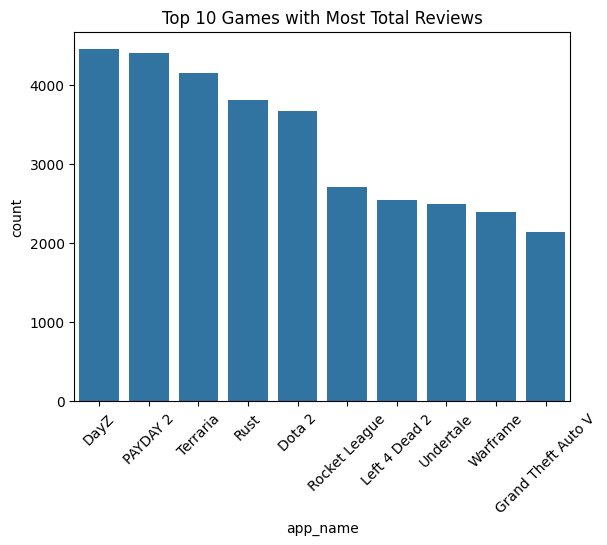

In [39]:
sns.countplot(x='app_name',data=df,order=pd.value_counts(df['app_name']).iloc[:10].index).set(title= 'Top 10 Games with Most Total Reviews')
plt.xticks(rotation=45)

DayZ has the most overall number of Steam reviews

In [23]:
#Filtering all the reviews of the game Terraria
df[df['app_name']=='Terraria']

,app_id,app_name,review_text,review_score,review_votes
3457,105600,Terraria,played for 390 hours and still not bored from ...,1,1
3458,105600,Terraria,Pros: - Insane amount of content. - Great comb...,1,1
3459,105600,Terraria,This is probably one of the best Games here on...,1,1
3460,105600,Terraria,Bad game. No content. 800+hrs/10 would spend y...,1,1
3461,105600,Terraria,I have had a really good experience with this ...,1,1
...,...,...,...,...,...
7613,105600,Terraria,-Was just about to exit my world. -'The skelet...,1,1
7614,105600,Terraria,"One of the best 2D games out there, and cheap ...",1,0
7615,105600,Terraria,Terraria is a 2D survival game that allows you...,1,0
7616,105600,Terraria,"You fight the undead, you fight nature, you ...",1,0


[Text(0.5, 1.0, 'Terraria Recommended vs Not Recommended')]

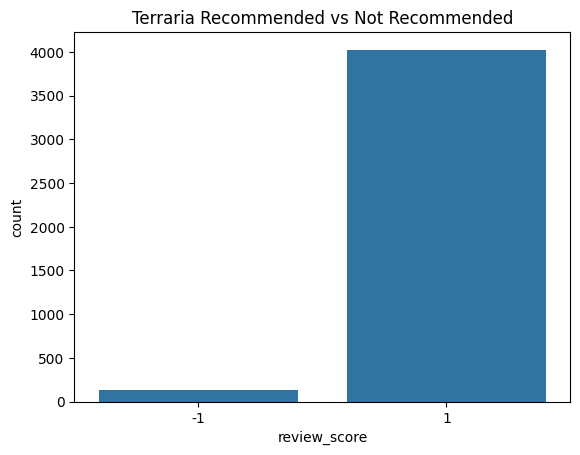

In [37]:
dfTerraria= df[df['app_name']=='Terraria']
sns.countplot(x='review_score',data=dfTerraria).set(title='Terraria Recommended vs Not Recommended')

There are more Recommended reviews for Terraria than Not Recommended.

In [25]:
#Game with the most number of recommended reviews
df_rec = df[df['review_score']==1].pivot_table(columns=['app_name'],aggfunc='size').sort_values(ascending=False).head(10)

In [26]:
df_rec

app_name
Terraria         4026
Dota 2           3130
PAYDAY 2         3061
Rust             3049
DayZ             2996
Rocket League    2571
Undertale        2416
Left 4 Dead 2    2364
Warframe         2163
Portal 2         1813
dtype: int64

<Axes: title={'center': 'Top 10 Games with Recommended Reviews'}, xlabel='app_name'>

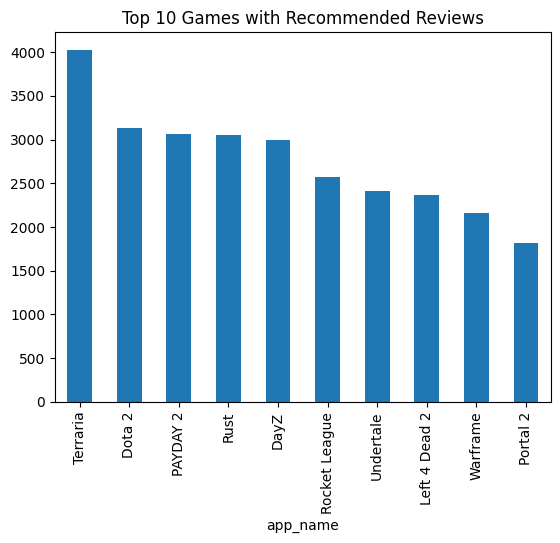

In [35]:
df_rec.plot.bar(title = "Top 10 Games with Recommended Reviews")

Terraria has the most number of positive reviews

[Text(0.5, 1.0, 'DayZ Recommended vs Not Recommended')]

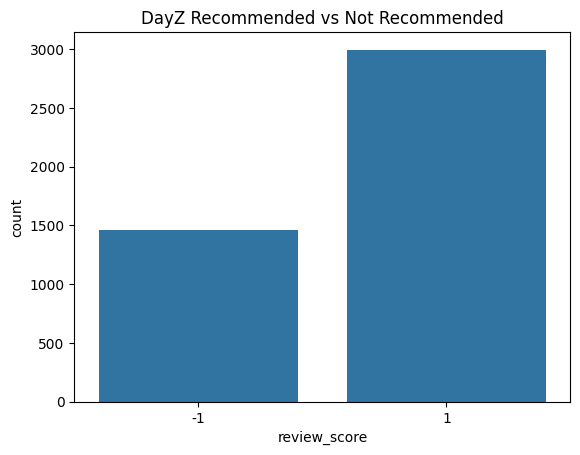

In [54]:
dfDayZ= df[df['app_name']=='DayZ']
sns.countplot(x='review_score',data=dfDayZ).set(title='DayZ Recommended vs Not Recommended')

In [51]:
(dfDayZ['review_score']== 1).sum()

2996

In [50]:
(dfDayZ['review_score']== -1).sum()

1457

DayZ has nearly half of the reviews that do not recommend the game.

<Axes: xlabel='review_score', ylabel='count'>

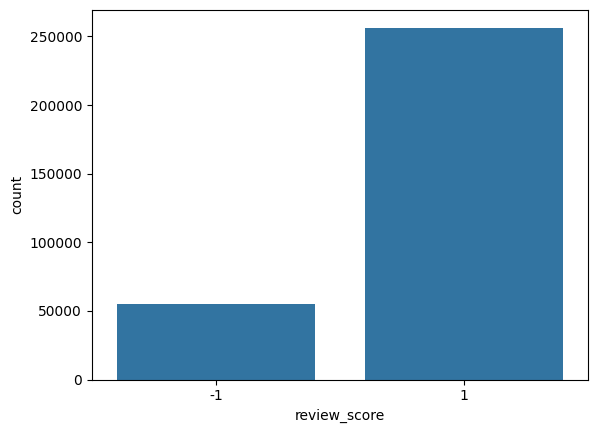

In [55]:
sns.countplot(data=df, x = 'review_score')

In [56]:
(df['review_score']== -1).sum()

54969

In [57]:
(df['review_score']== 1).sum()

256427

There are 54969 not recommended reviews total. Balance the data to have 50/50 rating

In [58]:
#filter for positive review
data_Positive = df[df['review_score'] == 1 ]
#randomly select 54969 rows
data_Positive = data_Positive.sample(n=54969, random_state=42)  # Set random_state for reproducibility

In [61]:
data_Positive.shape

(54969, 5)

In [63]:
#filter for negative review
data_Negative = df[df['review_score'] == -1]
data_Negative.shape

(54969, 5)

In [65]:
data_Negative_over = data_Negative.sample(8000, replace=True)
df_balance_reviews = pd.concat([data_Positive, data_Negative_over], axis=0)

In [68]:
df_balance_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
272567,42680,Call of Duty: Modern Warfare 3,Single player campaign is like every previous ...,1,0
28351,203770,Crusader Kings II,Crusader Kings 2 is one of my favourite games....,1,0
210865,324080,Rising World,Early Access Review,1,1
319122,94400,Nidhogg,An amazing multiplayer fighting game. Absolute...,1,0
286674,47780,Dead Space 2,Totally worth the money. It gets better if you...,1,0


Downloading stopwords from nltk

In [70]:
#Setting the stop words
import nltk
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jerry\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [71]:
df = df_balance_reviews
x_data = df['review_text']       # Reviews/Input
y_data = df['review_score']    # Sentiment/Output

# PRE-PROCESS REVIEW
x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

# ENCODE SENTIMENT -> 0 & 1
#1 to Recommend 1 -1 to Not Recommend 0
y_data = y_data.replace(1, 1)
### simmilarly for y_data
y_data = y_data.replace(-1, 0)

Splitting the dataset for training

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=101)

Making a function to get the max length for padding

In [73]:
def get_max_length(x_train):
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [74]:
max_length = get_max_length(X_train)
print(max_length)

32


Loading the Tokenizer to convert the words into sequences and then add the padding to make the rows equal lenght.

In [75]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # False becuase we already did it. 
token.fit_on_texts(X_train)
x_train = token.texts_to_sequences(X_train)
x_test = token.texts_to_sequences(X_test)

### this is the code to add the pad to x_train
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')

############# add pad to x_test   ########################### 
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # we need to add 1 because of 0 padding

Building the RNN with LSTM Model. 

In [76]:
# ARCHITECTURE
EMBED_DIM = 3200
LSTM_OUT = 64

#### add the model here:
model = Sequential()

#model.add(Embedding(input_dim=max_length, output_dim=LSTM_OUT,input_length=max_length))
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(units=1, activation='sigmoid'))

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Adding a Checkpoint to save the model.
checkpoint = ModelCheckpoint('models/LSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 3200)          159766400 
                                                                 
 lstm (LSTM)                 (None, 64)                835840    
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 160,602,305
Trainable params: 160,602,305
Non-trainable params: 0
_________________________________________________________________


In [78]:
history = model.fit(x_train, y_train, epochs=3, batch_size=20, callbacks= [checkpoint],validation_data=(x_test, y_test))

Epoch 1/3
2519/2519 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8811
Epoch 1: accuracy improved from -inf to 0.88107, saving model to models\LSTM.h5
2519/2519 [==============================] - 112s 43ms/step - loss: 0.3257 - accuracy: 0.8811 - val_loss: 0.2826 - val_accuracy: 0.8931
Epoch 2/3
2519/2519 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9163
Epoch 2: accuracy improved from 0.88107 to 0.91629, saving model to models\LSTM.h5
2519/2519 [==============================] - 107s 42ms/step - loss: 0.2242 - accuracy: 0.9163 - val_loss: 0.3006 - val_accuracy: 0.8915
Epoch 3/3
2519/2519 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9421
Epoch 3: accuracy improved from 0.91629 to 0.94207, saving model to models\LSTM.h5
2519/2519 [==============================] - 108s 43ms/step - loss: 0.1621 - accuracy: 0.9421 - val_loss: 0.3271 - val_accuracy: 0.8902


Plotting the loss

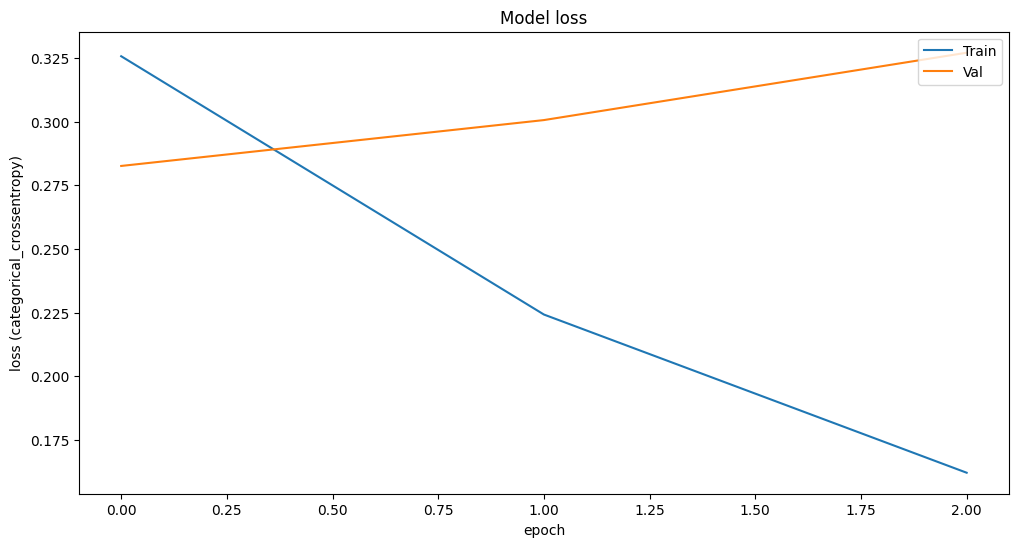

In [79]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')

Plotting the Accuracy

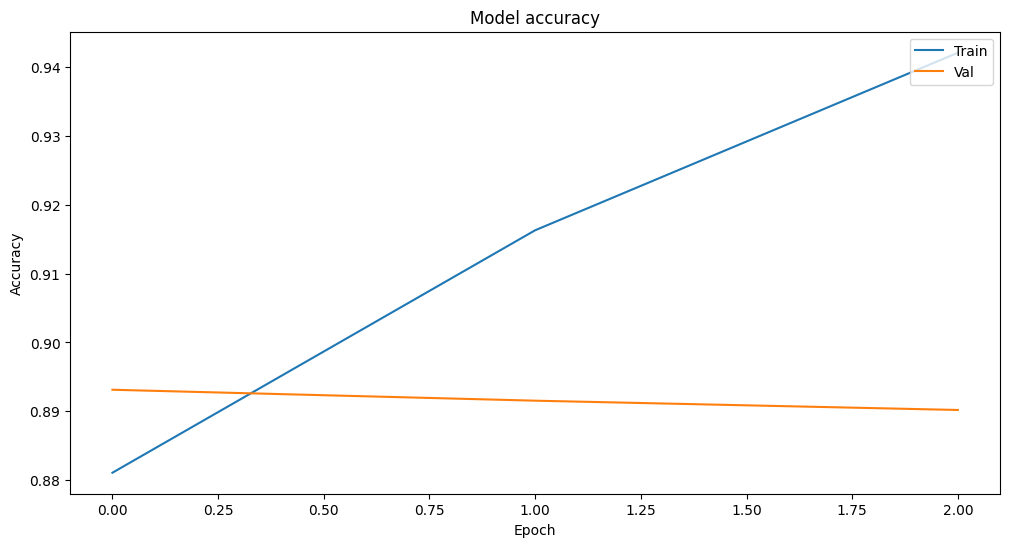

In [80]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['accuracy'][:])
plt.plot(model.history.history['val_accuracy'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

Now we can test out the model.

In [107]:
#I grab a random review from the dataframe
value = 12345
df.iloc[value]

app_id                                                      42680
app_name                           Call of Duty: Modern Warfare 3
review_text     Has an amazing campaign a smooth game that is ...
review_score                                                    1
review_votes                                                    0
Name: 272529, dtype: object

Cleaning the data before loading it to the model for prediction

In [103]:
review = df.iloc[value]['review_text']

regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

Tokenized and Encoded the word so it can be loaded into the model for prediction

In [104]:
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')

In [105]:
result = model.predict(tokenize_words)

if result >= .50:
    print('Postive')
else:
    print('Negative')

1/1 [==============================] - 0s 15ms/step
Postive


In [116]:
#I grab a random review from the dataframe
value = 54321
df.iloc[value]

app_id                                                     424280
app_name                                               Iron Snout
review_text     I Just downloaded this game and i can't stop p...
review_score                                                    1
review_votes                                                    0
gameID                                                        218
Name: 271950, dtype: object

In [114]:
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
result = model.predict(tokenize_words)

if result >= .50:
    print('Postive')
else:
    print('Negative')

1/1 [==============================] - 0s 44ms/step
Postive


In [117]:
#I grab a random review from the dataframe
value = 1234
df.iloc[value]

app_id                                                     454380
app_name                                   Champions of Breakfast
review_text       10/10 This product is so worth it. Anyone th...
review_score                                                    1
review_votes                                                    0
gameID                                                        640
Name: 283121, dtype: object

In [118]:
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
result = model.predict(tokenize_words)

if result >= .50:
    print('Postive')
else:
    print('Negative')

1/1 [==============================] - 0s 22ms/step
Postive


## Conclusion

After sampling several games' review text. The RNN LSTM model is able to correctly classify the review text as either Positive or Negative. While the validation accuracy percentage 89.02% is lower than the training accuracy of 94.21%, the model works decent enough for the few validation review scores I inserted to test.

In [2]:
!set PATH=/Library/TeX/texbin:$PATH